In [58]:
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import numpy as np
from os.path import join
from json import load
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])


# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

def diff(v1, v2):
    return (v1-v2)*100/v1

def get_motion_activity(video, fps, duration):
    with open(f"/home/akram/ucalgary/research/istream-player/dataset/videos-raw/motion_activity/{video}.json") as f:
        ma = load(f)
    return [sum(ma[fps * s : fps * (s + 1)]) / fps for s in range(duration)]

def get_segment_sizes(video, duration, seg_type, crf):
    dash_dir = f"/home/akram/ucalgary/research/istream-player/dataset/videos-raw/dash/{video}/{video}1s_{duration}s_{seg_type}_crf{crf}"
    return [os.path.getsize(f"{dash_dir}/segment_{s+1}.m4s") for s in range(duration)]


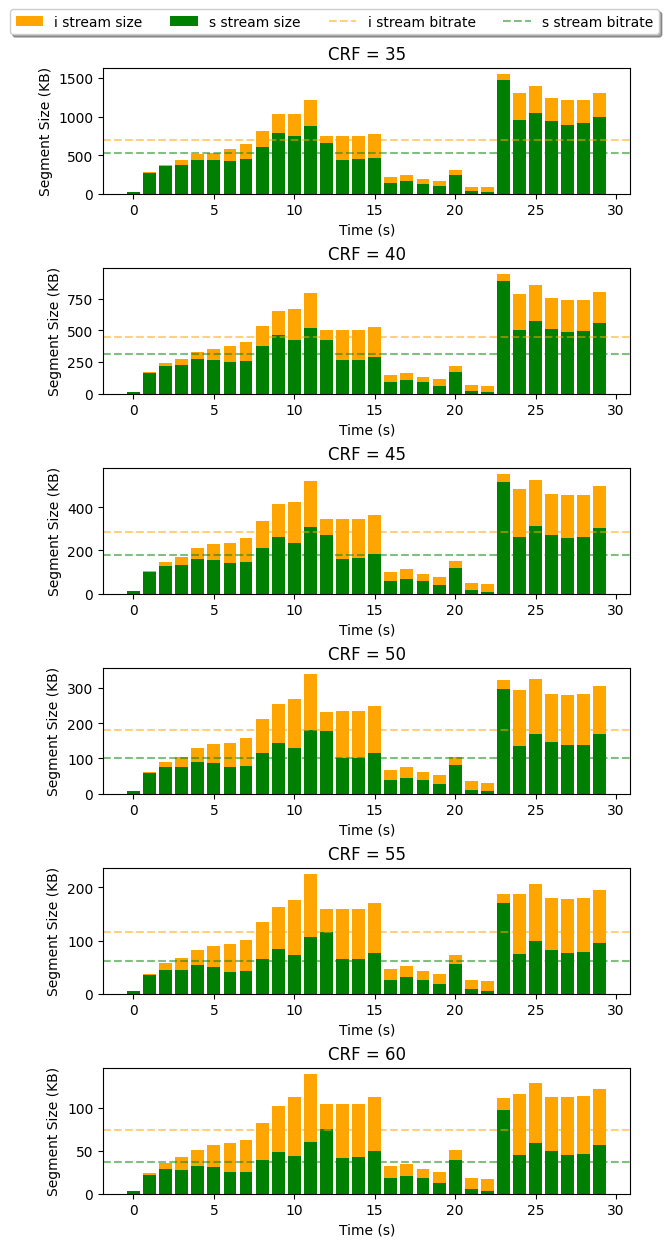

In [17]:
duration = 30
video = 'bbb'
fps = 24
crfs = [35, 40, 45, 50, 55, 60]

df = pd.DataFrame({"time": range(duration)})

df["motion_activity"] = get_motion_activity(video, fps, duration)

fig, ax = plt.subplots(len(crfs), 1, constrained_layout=True, figsize=(6, 2 * len(crfs)))
for crf in crfs:
    df[f"size_i_crf{crf}"] = get_segment_sizes(video, duration, 'i', crf)
    df[f"size_s_crf{crf}"] = get_segment_sizes(video, duration, 's', crf)

lns = []

for i, crf in enumerate(crfs):
    lns = []
    lns.append(ax[i].bar(df.time, df[f"size_i_crf{crf}"] / 1000, color='orange'))
    lns.append(ax[i].bar(df.time, df[f"size_s_crf{crf}"] / 1000, color='green'))
    ax[i].set_ylabel("Segment Size (KB)")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_title(f"CRF = {crf}")

    lns.append(ax[i].axhline(y=df[f"size_i_crf{crf}"].mean() / 1000,color='orange',linestyle='--', alpha=0.5))
    lns.append(ax[i].axhline(y=df[f"size_s_crf{crf}"].mean() / 1000,color='green',linestyle='--', alpha=0.5))


fig.legend(
    lns,
    ['i stream size', 's stream size', 'i stream bitrate', 's stream bitrate'],
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True, shadow=True, ncol=5
)


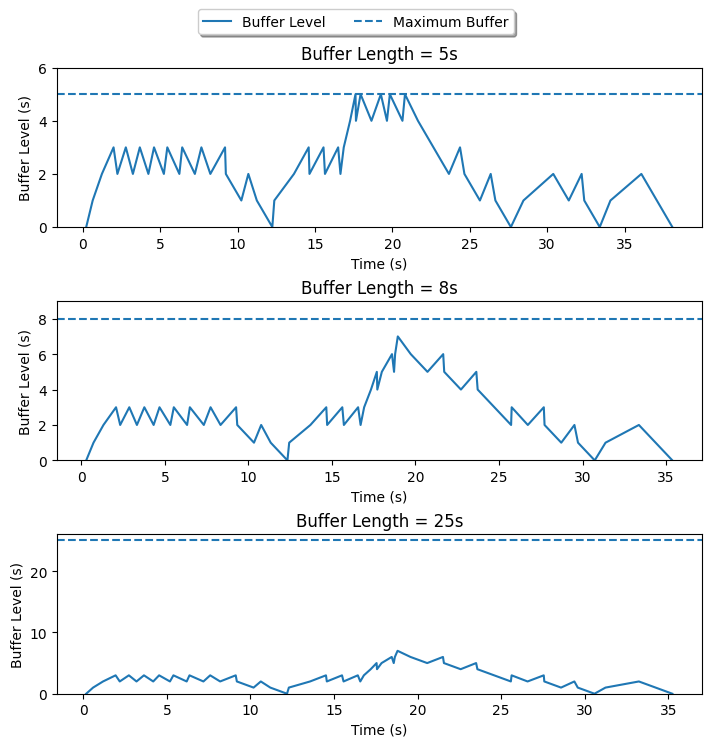

In [18]:
fig, ax = plt.subplots(3,1, constrained_layout=True, figsize=(7,7))
df_5 = pd.read_json('./data/5s.json')
df_8 = pd.read_json('./data/8s.json')
df_25 = pd.read_json('./data/25s.json')

ax[0].plot(df_5.time, df_5.level)
ax[0].set_ylim(0, 6)
ax[0].set_ylabel("Buffer Level (s)")
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Buffer Length = 5s")
ax[0].axhline(y=5, linestyle='--')

ax[1].plot(df_8.time, df_8.level)
ax[1].set_ylim(0, 9)
ax[1].set_ylabel("Buffer Level (s)")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Buffer Length = 8s")
ax[1].axhline(y=8, linestyle='--')

ax[2].plot(df_25.time, df_25.level)
ax[2].set_ylim(0, 26)
ax[2].set_ylabel("Buffer Level (s)")
ax[2].set_xlabel("Time (s)")
ax[2].set_title("Buffer Length = 25s")
ax[2].axhline(y=25, linestyle='--')


fig.legend(
    ['Buffer Level', 'Maximum Buffer'],
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True, shadow=True, ncol=5
)

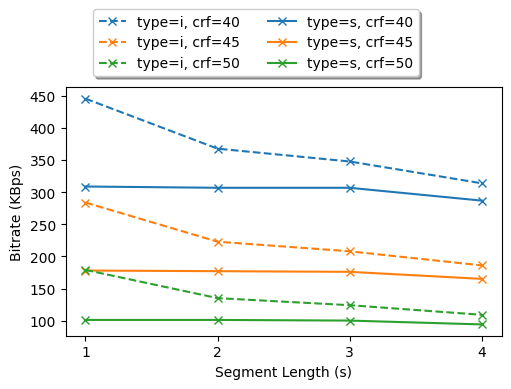

In [56]:
import itertools
import os

import numpy as np


duration = 30
video = 'bbb'
# crfs = list(range(30, 61, 10))
crfs = [40, 45, 50]
seg_lens = list(range(1, 5))
seg_types = ['i', 's']

rows = []

for crf, seg_len, seg_type in itertools.product(crfs, seg_lens, seg_types):
    dash_dir = f"/home/akram/ucalgary/research/istream-player/dataset/videos-raw/dash/{video}/{video}{seg_len}s_{duration}s_{seg_type}_crf{crf}"
    sizes = []
    try:
        for s in range(duration):
            sizes.append(os.path.getsize(f"{dash_dir}/segment_{s+1}.m4s") )
    except:
        pass

    rows.append({
        'crf': crf,
        "seg_len": seg_len,
        "seg_type": seg_type,
        "bitrate": np.mean([sizes])/seg_len
    })

df = pd.DataFrame.from_records(rows)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3))
for i, crf in enumerate(crfs):
    plotdfi = df[(df['seg_type'] == 'i') & (df['crf'] == crf)]
    plotdfs = df[(df['seg_type'] == 's') & (df['crf'] == crf)]
    ax.plot(plotdfi.seg_len, plotdfi.bitrate//1000, marker='x', label=f'type=i, crf={crf}', color=COLORS[i], linestyle='--')
    ax.plot(plotdfs.seg_len, plotdfs.bitrate//1000, marker='x', label=f'type=s, crf={crf}', color=COLORS[i])

ax.set_xticks(seg_lens)
ax.set_xlabel('Segment Length (s)')
ax.set_ylabel('Bitrate (KBps)')
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    flip(handles, 2), flip(labels, 2),
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True, shadow=True, ncol=2
)

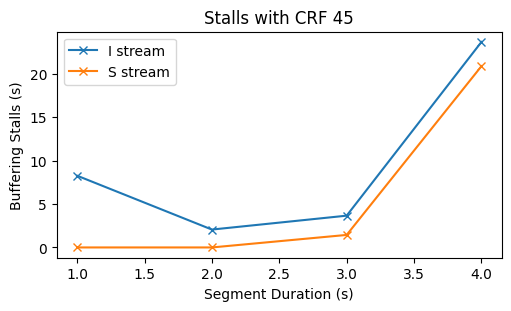

In [24]:
df = pd.DataFrame(
    {
        "segDuration": [1, 2, 3, 4],
        "i": [8269.668400287628, 2060.9148740768433, 3662.550687789917, 23684.20499563217],
        "s": [0, 0, 1443.4109330177307, 20893.349289894104],
    }ax
)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3))
ax.plot(df["segDuration"], df['i']/1000, label='i', marker='x')
ax.plot(df["segDuration"], df['s']/1000, label='s', marker='x')
ax.set_xlabel("Segment Duration (s)")
ax.set_ylabel("Buffering Stalls (s)")
ax.set_title("Stalls with CRF 45")
ax.legend(['I stream', 'S stream'])


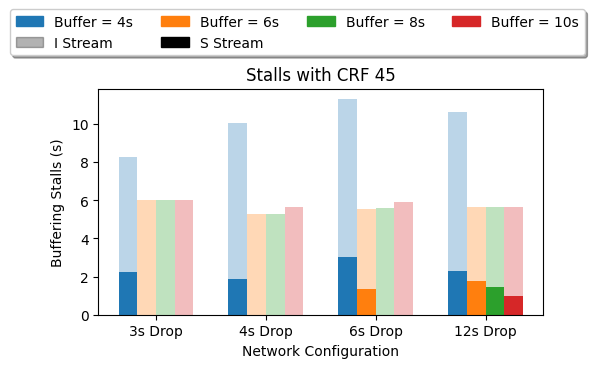

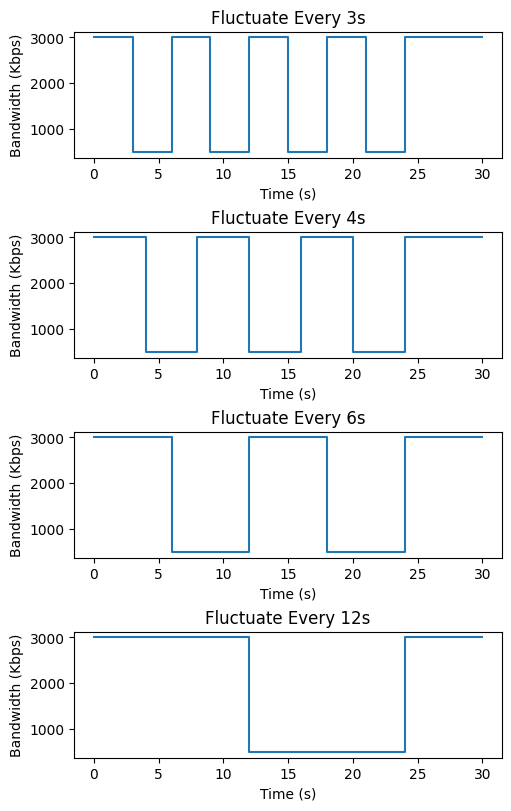

In [86]:
import numpy as np

df_s = pd.DataFrame(
    {
        "network": [
            "3s Drop",
            "4s Drop",
            "6s Drop",
            "12s Drop",
        ],
        "10s": [0, 0, 0, 999.6278285980225],
        "4s": [2252.434015274048, 1873.3749389648438, 3021.838903427124, 2282.2320461273193],
        "6s": [0, 0, 1367.2871589660645, 1758.368968963623],
        "8s": [0, 0, 0, 1464.7917747497559],
    }
)

df_i = pd.DataFrame(
    {
        "network": [
            "3s Drop",
            "4s Drop",
            "6s Drop",
            "12s Drop",
        ],
        "10s": [5996.744155883789, 5668.726205825806, 5925.642013549805, 5633.446216583252],
        "4s": [8278.936624526978, 10064.846754074097, 11283.118963241577, 10613.044023513794],
        "6s": [6006.399154663086, 5280.77507019043, 5551.188945770264, 5654.756784439087],
        "8s": [6006.020069122314, 5284.1432094573975, 5576.2059688568115, 5629.256963729858],
    }
)
buffers = ("4s", "6s", "8s", "10s")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3))
width = 0.17  # the width of the bars
x = np.arange(4)  # the label locations


for i, buffer in enumerate(buffers):
    offset = width * i
    ax.bar(x + offset, df_i[buffer] / 1000, width, label=buffer, color=COLORS[i], alpha=0.3)
    ax.bar(x + offset, df_s[buffer] / 1000, width, label=buffer, color=COLORS[i])

ax.set_xticks(x + width * 1.5, df_s["network"])
ax.set_xlabel("Network Configuration")
ax.set_ylabel("Buffering Stalls (s)")
ax.set_title("Stalls with CRF 45")
fig.legend(
    handles=[
        mpatches.Patch(color=COLORS[0], label=f"Buffer = 4s"),
        mpatches.Patch(color="black", label=f"I Stream", alpha=0.3), 
        mpatches.Patch(color=COLORS[1], label=f"Buffer = 6s"),
        mpatches.Patch(color="black", label=f"S Stream"),
        mpatches.Patch(color=COLORS[2], label=f"Buffer = 8s"),
        mpatches.Patch(color=COLORS[3], label=f"Buffer = 10s"),
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    fancybox=True,
    shadow=True,
    ncol=4,
)

drops = [3, 4, 6, 12]
fig, ax = plt.subplots(len(drops), 1, constrained_layout=True, figsize=(5, 2 * len(drops)))

for i, drop in enumerate(drops):
    # print(list(range(25, drop)) + [30])
    # print([3000, 500] * (12//drop) + [3000] + [3000])
    ax[i].step(
        list(range(0, 25, drop)) + [30],
        [3000, 500] * (12//drop) + [3000] + [3000],
        where='post'
    )
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Bandwidth (Kbps)')
    ax[i].set_title(f'Fluctuate Every {drop}s')


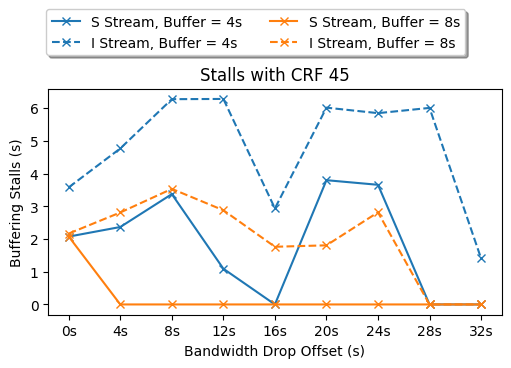

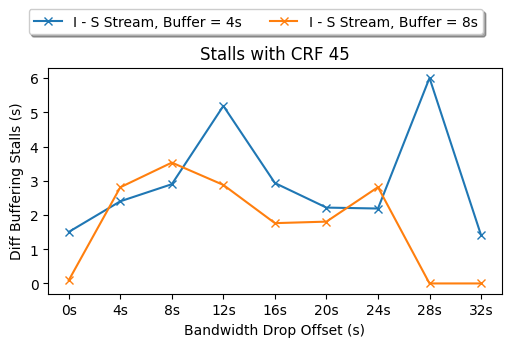

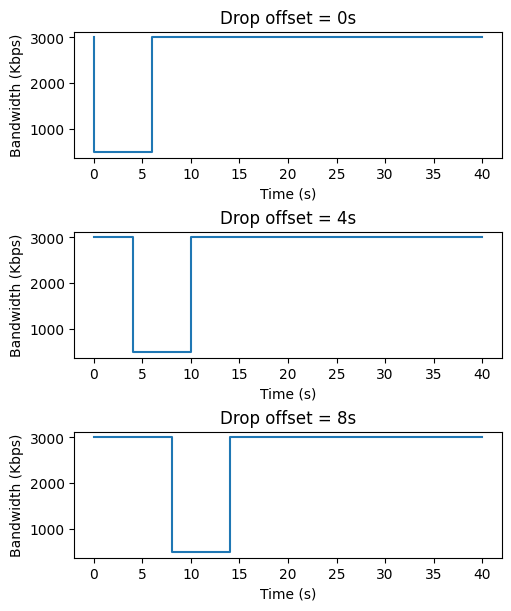

In [91]:
df_s = pd.DataFrame(
    {
        "network": [
            "0s",
            "4s",
            "8s",
            "12s",
            "16s",
            "20s",
            "24s",
            "28s",
            "32s",
        ],
        "10s": [2.072, 0, 0, 0, 0, 0, 0, 0, 0],
        "4s": [2.073, 2.366, 3.371, 1.091, 0, 3.796, 3.655, 0, 0],
        "6s": [2.073, 0.928, 0, 0, 0, 1.899, 0.629, 0, 0],
        "8s": [2.073, 0, 0, 0, 0, 0, 0, 0, 0],
    }
)

df_i = pd.DataFrame(
    {
        "network": [
            "0s",
            "4s",
            "8s",
            "12s",
            "16s",
            "20s",
            "24s",
            "28s",
            "32s",
        ],
        "10s": [2.164, 2.807, 3.559, 2.889, 0.333, 0.37, 0, 0, 0],
        "4s": [3.578, 4.766, 6.271, 6.278, 2.934, 6.012, 5.844, 6.004, 1.41],
        "6s": [2.165, 2.788, 3.551, 2.893, 1.714, 3.86, 4.386, 0.563, 0],
        "8s": [2.166, 2.81, 3.531, 2.878, 1.762, 1.806, 2.814, 0, 0],
    }
)

buffers = ("4s", "8s")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3))
fig2, ax2 = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3))

for i, buffer in enumerate(buffers):
    ax.plot(df_s["network"], df_s[buffer], label=f"S Stream, Buffer = {buffer}", marker="x", color=COLORS[i])
    ax.plot(df_s["network"], df_i[buffer], label=f"I Stream, Buffer = {buffer}", marker="x", color=COLORS[i], linestyle='--')

    ax2.plot(df_s["network"], df_i[buffer] - df_s[buffer], label=f"I - S Stream, Buffer = {buffer}", marker="x", color=COLORS[i])


ax.set_xlabel("Bandwidth Drop Offset (s)")
ax.set_ylabel("Buffering Stalls (s)")
ax.set_title("Stalls with CRF 45")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1), fancybox=True, shadow=True, ncol=2)

ax2.set_xlabel("Bandwidth Drop Offset (s)")
ax2.set_ylabel("Diff Buffering Stalls (s)")
ax2.set_title("Stalls with CRF 45")
fig2.legend(loc="lower center", bbox_to_anchor=(0.5, 1), fancybox=True, shadow=True, ncol=2)


drops = list(range(0, 9, 4))
fig, ax = plt.subplots(len(drops), 1, constrained_layout=True, figsize=(5, 2 * len(drops)))

for i, drop in enumerate(drops):
    ax[i].step(
        [0, drop, drop + 6, 40],
        [3000, 500, 3000, 3000],
        where='post'
    )
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Bandwidth (Kbps)')
    ax[i].set_title(f'Drop offset = {drop}s')
